In [771]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

# Cleaning

In [772]:
df = pd.read_csv('../data/EdStatsData.csv')

In [775]:
df_non_null = df.count()
df_non_null = df_non_null.iloc[4:-1]
df_non_null.index = pd.DatetimeIndex(df_non_null.index)
df_non_null = df_non_null.resample('5AS').mean()
df_non_null.index = df_non_null.index.strftime('%Y')

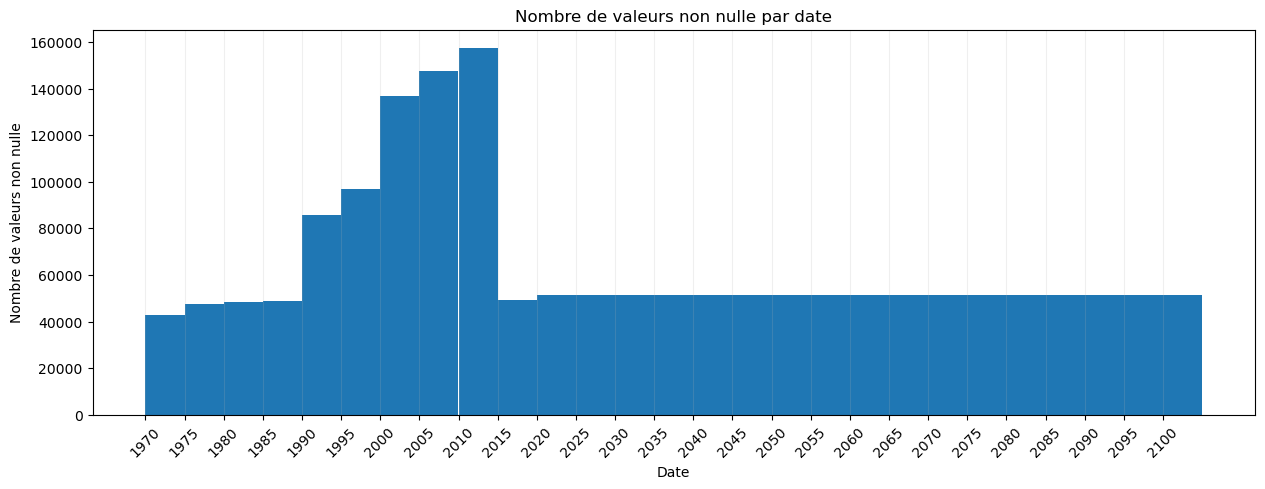

In [776]:
fig, ax = plt.subplots(figsize=(15,5))
n = np.arange(len(df_non_null.index))
ax.bar(n, df_non_null, width=1)
ax.grid(True, axis='x', alpha=0.2)
ax.set_title("Nombre de valeurs non nulle par date")
ax.set_xlabel('Date')
ax.set_ylabel('Nombre de valeurs non nulle')
ax.set_xticks(n - 0.5,labels=df_non_null.index, rotation=45)

In [777]:
# Delete rows where values are all null in all non-base column

base_col = ["Country Name", "Country Code", "Indicator Name", "Indicator Code"]
col = df.columns
all_col = [i for i in col if not i in base_col]

df.dropna(axis = 0, how='all', subset=all_col, inplace=True)
df.dropna(axis = 1, how='all', inplace=True)

In [778]:
df_country = pd.read_csv("../data/EdStatsCountry.csv")

In [779]:
region = list(df_country[df_country['Region'].isnull()]["Country Code"])

In [780]:
# On filtre les régions pour ne garder que les pays
df = df[~df['Country Code'].isin(region)]

# Indicator selection

In [781]:
df_past = df[list(df.loc[:, 'Country Name' : 'Indicator Code']) + list(df.loc[:, '2010':'2015'])]
df_past = df_past[(df_past.isnull().sum(axis=1) / 68) < 0.7]

In [782]:
# Past df filter on selected indicator
ind_list_past = ["SE.SEC.ENRR", "SE.TER.ENRR", "IT.NET.USER.P2", "NY.GNP.PCAP.PP.CD", "SP.POP.TOTL", "SP.SEC.TOTL.IN", "SP.TER.TOTL.IN"]
df_past = df_past[df_past["Indicator Code"].isin(ind_list_past)]


In [783]:
# Filter on date range 2010-2015 and filter country which has only missing value for one of the indicator

df_past = df_past[df_past.loc[:, '2010':'2015'].isnull().sum(axis=1) / 6 != 1] # Filter rows with only missing values
country_to_keep = [i for i in df_past['Country Name'].value_counts().index if df_past['Country Name'].value_counts()[i] == 7] # Filter country which do not have all indicator remaining
len(country_to_keep)

148

In [784]:
df_past = df_past[df_past['Country Name'].isin(country_to_keep)]


In [785]:
# Create a unique value for all indicators, based of more recent valid value between 2010 and 2015
df_int = df_past.loc[:, '2010':]
df_past = df_past.loc[:, 'Country Name':'Indicator Code']
df_past['Value'] = df_int[df_int.columns[::-1]].fillna(method='bfill', axis=1).iloc[:, 0]

In [786]:
# Pivot the table and group some indicators
df_pivot = pd.pivot_table(df_past, values=['Value'], index=['Country Name'], columns=['Indicator Code', 'Indicator Name'])
df_pivot.columns = df_pivot.columns.droplevel(0)
df_pivot[('', 'Number of internet users')] = df_pivot['IT.NET.USER.P2'].iloc[:, 0] / 100 * df_pivot['SP.POP.TOTL'].iloc[:, 0]
df_pivot[('','Number of people in sec')] = df_pivot['SE.SEC.ENRR'].iloc[:, 0] / 100 * df_pivot['SP.SEC.TOTL.IN'].iloc[:, 0]
df_pivot[('','Number of people in ter')] = df_pivot['SE.TER.ENRR'].iloc[:, 0] / 100 * df_pivot['SP.TER.TOTL.IN'].iloc[:, 0]
df_pivot[('','Number of people in sec and ter')] = df_pivot.loc[:, pd.IndexSlice[:, 'Number of people in sec']].iloc[:, 0] + df_pivot.loc[:, pd.IndexSlice[:, 'Number of people in ter']].iloc[:, 0]
df_pivot.drop(['IT.NET.USER.P2', 'SE.SEC.ENRR', 'SE.TER.ENRR', 'SP.POP.TOTL', 'SP.SEC.TOTL.IN', 'SP.TER.TOTL.IN', ('', 'Number of people in ter'), ('', 'Number of people in sec')], axis=1, inplace=True)
df_pivot.columns = df_pivot.columns.droplevel(0)

In [787]:
def gini(arr):
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i + 1) * yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/sorted_arr.sum() - const_

In [788]:
df_stats = pd.DataFrame()
df_stats['Mean'] = df_pivot.mean()
df_stats['Median'] = df_pivot.median()
df_stats['Variance'] = df_pivot.var()
df_stats['Std'] = df_pivot.std()
df_stats['Skew'] = df_pivot.skew()
df_stats['Kurtosis'] = df_pivot.kurtosis()
quantile = df_pivot.quantile([.25, .75], interpolation='nearest')
df_stats['Q1']= quantile.loc[0.25]
df_stats['Q3']= quantile.loc[0.75]
df_stats['Gini'] = [gini(df_pivot[c].values) for c in df_pivot.columns]

df_stats

,Mean,Median,Variance,Std,Skew,Kurtosis,Q1,Q3,Gini
Indicator Name,,,,,,,,,
"GNI per capita, PPP (current international $)",2.024446e+04,1.328500e+04,4.598381e+08,2.144384e+04,1.862805,4.464603,4290.000000,2.783000e+04,0.529269
Number of internet users,2.005717e+07,3.900826e+06,4.577974e+15,6.766073e+07,7.706463,69.367004,991505.706000,1.141945e+07,0.810245
Number of people in sec and ter,5.101577e+06,1.045080e+06,3.112276e+14,1.764164e+07,7.347147,58.622165,342655.024358,3.304364e+06,0.803476


In [789]:
# Filter country which has value under Q1 for one of the Indicator
ind = df_stats.index
country = list()
for i in ind:
    q1 = df_stats.loc[i, 'Q1']
    country.append(df_pivot[df_pivot[i] < q1].index)
country = list(chain(*country))

In [790]:
df_pivot = df_pivot.filter(items = [i for i in df_pivot.index if i not in country], axis = 0)
len(df_pivot)

80

In [791]:
# Filter country which has value over Q3 for all of the Indicator
country_ = list()
for i in ind:
    med = df_stats.loc[i, 'Q3']
    country_.append(df_pivot[df_pivot[i] < med].index)
country_ = list(chain(*country_))

In [792]:
df_pivot = df_pivot.filter(items = [i for i in df_pivot.index if i not in country_], axis = 0)
df_pivot

Indicator Name,"GNI per capita, PPP (current international $)",Number of internet users,Number of people in sec and ter
Country Name,,,
Australia,45510.0,2.011639e+07,3.804760e+06
France,41800.0,5.642692e+07,8.399026e+06
Germany,49060.0,7.154914e+07,1.009073e+07
Italy,37200.0,3.530981e+07,6.432494e+06
Japan,42230.0,1.157721e+08,1.102509e+07
"Korea, Rep.",34520.0,4.573420e+07,6.664865e+06
Saudi Arabia,55700.0,2.196890e+07,4.945091e+06
Spain,34760.0,3.654951e+07,5.277051e+06
United Kingdom,41190.0,5.991875e+07,8.789096e+06


In [793]:
df_pivot['Rank'] = df_pivot.rank(ascending=False).sum(axis=1)
df_pivot.sort_values('Rank', ascending=True, inplace=True)
df_pivot

Indicator Name,"GNI per capita, PPP (current international $)",Number of internet users,Number of people in sec and ter,Rank
Country Name,,,,
United States,57900.0,2.392419e+08,4.354928e+07,3.0
Germany,49060.0,7.154914e+07,1.009073e+07,9.0
Japan,42230.0,1.157721e+08,1.102509e+07,9.0
United Kingdom,41190.0,5.991875e+07,8.789096e+06,15.0
France,41800.0,5.642692e+07,8.399026e+06,16.0
Saudi Arabia,55700.0,2.196890e+07,4.945091e+06,20.0
"Korea, Rep.",34520.0,4.573420e+07,6.664865e+06,22.0
Italy,37200.0,3.530981e+07,6.432494e+06,23.0
Australia,45510.0,2.011639e+07,3.804760e+06,24.0


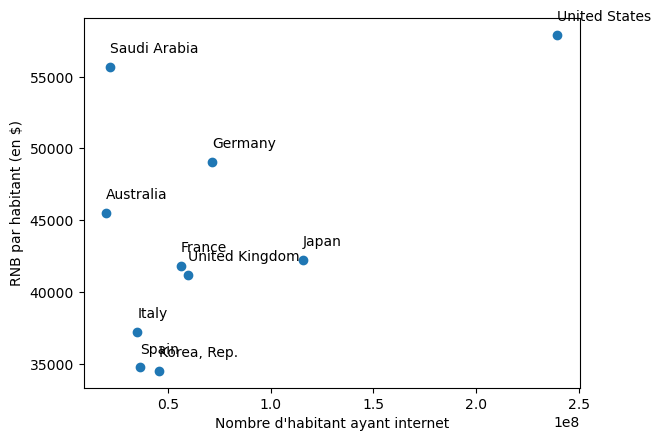

In [794]:
x = df_pivot['Number of internet users']
y = df_pivot['GNI per capita, PPP (current international $)']
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel("Nombre d'habitant ayant internet")
ax.set_ylabel('RNB par habitant (en $)')
for i, c in enumerate(df_pivot.index):
    ax.annotate(c, (x[i], y[i]), xytext = (x[i], y[i] + 1000))

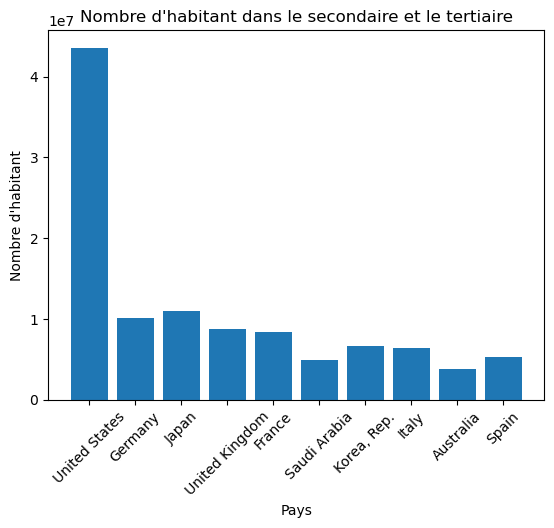

In [795]:
fig, ax = plt.subplots()
width = 1
n = np.arange(len(df_pivot.index))
ax.bar(n, df_pivot['Number of people in sec and ter'], width=width-0.2)
ax.set_title("Nombre d'habitant dans le secondaire et le tertiaire")
ax.set_xlabel('Pays')
ax.set_ylabel("Nombre d'habitant")
ax.set_xticks(n,labels=df_pivot.index, rotation=45)

In [796]:
df_prev = df[list(df.loc[:, 'Country Name' : 'Indicator Code']) + list(df.loc[:, '2020':])]
df_prev

,Country Name,Country Code,Indicator Name,Indicator Code,2020,2025,2030,2035,2040,2045,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
91625,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91626,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91627,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91628,Afghanistan,AFG,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91631,Afghanistan,AFG,"Adjusted net enrolment rate, primary, gender p...",UIS.NERA.1.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886926,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886927,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886928,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [797]:
ind_prev = ['PRJ.POP.ALL.4.MF', 'PRJ.POP.ALL.3.MF']
df_prev = df_prev[df_prev['Indicator Code'].isin(ind_prev)]
df_prev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 98940 to 886921
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    332 non-null    object 
 1   Country Code    332 non-null    object 
 2   Indicator Name  332 non-null    object 
 3   Indicator Code  332 non-null    object 
 4   2020            332 non-null    float64
 5   2025            332 non-null    float64
 6   2030            332 non-null    float64
 7   2035            332 non-null    float64
 8   2040            332 non-null    float64
 9   2045            332 non-null    float64
 10  2050            332 non-null    float64
 11  2055            332 non-null    float64
 12  2060            332 non-null    float64
 13  2065            332 non-null    float64
 14  2070            332 non-null    float64
 15  2075            332 non-null    float64
 16  2080            332 non-null    float64
 17  2085            332 non-null

In [798]:
df_prev = df_prev[df_prev['Country Name'].isin(df_pivot.index)]
df_prev = df_prev.groupby('Country Name').sum()
df_prev

/var/folders/j4/d721p55x7jxdfp8krqsjjqh00000gn/T/ipykernel_15029/69575363.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_prev = df_prev.groupby('Country Name').sum()


,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Country Name,,,,,,,,,,,,,,,,,
Australia,16494.54,18258.47,20071.58,21924.35,23778.71,25566.76,27268.56,28913.51,30520.58,31977.75,33273.06,34389.17,35305.63,36020.58,36546.95,36912.95,37128.63
France,38785.33,42034.38,45216.77,48235.14,51034.40,53601.66,56004.45,58262.65,60380.28,62272.55,63956.33,65466.39,66813.41,67985.76,68977.09,69773.08,70366.14
Germany,57156.13,58079.44,58766.78,59213.81,59573.81,59812.79,59831.04,59639.15,59365.48,59092.59,58896.21,58754.02,58590.57,58275.64,57812.02,57272.69,56639.96
Italy,28451.21,30893.41,33301.34,35390.45,37266.28,38950.84,40462.33,41779.53,42867.50,43626.72,44105.45,44419.84,44617.96,44714.45,44673.24,44463.38,44101.99
Japan,91799.18,93486.61,94447.32,94577.56,93853.39,92468.63,90692.69,88718.83,86560.33,84081.39,81325.07,78453.58,75655.20,73036.36,70589.03,68250.71,65953.11
"Korea, Rep.",33916.45,35625.48,37092.75,38189.29,38892.64,39167.85,38961.84,38260.83,37160.85,35810.92,34362.21,32916.63,31522.13,30174.48,28877.81,27640.96,26501.12
Saudi Arabia,14097.26,17371.02,20997.82,24603.10,28227.26,31809.61,35333.36,38751.06,41966.78,44793.23,47245.32,49334.01,51029.65,52348.55,53260.06,53780.52,53927.08
Spain,19217.47,21461.37,23756.40,25873.15,27819.76,29581.20,31229.42,32814.98,34305.77,35537.81,36461.83,37130.57,37629.62,38045.04,38391.24,38623.21,38665.55
United Kingdom,22747.88,25111.54,27786.19,30642.02,33572.48,36531.87,39492.05,42459.58,45464.41,48408.38,51226.17,53869.49,56306.76,58522.02,60528.15,62344.02,63955.45


/var/folders/j4/d721p55x7jxdfp8krqsjjqh00000gn/T/ipykernel_15029/1290155444.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=df_prev.columns, rotation=45)


[Text(0, 0, '2020'),
 Text(1, 0, '2025'),
 Text(2, 0, '2030'),
 Text(3, 0, '2035'),
 Text(4, 0, '2040'),
 Text(5, 0, '2045'),
 Text(6, 0, '2050'),
 Text(7, 0, '2055'),
 Text(8, 0, '2060'),
 Text(9, 0, '2065'),
 Text(10, 0, '2070'),
 Text(11, 0, '2075'),
 Text(12, 0, '2080'),
 Text(13, 0, '2085'),
 Text(14, 0, '2090'),
 Text(15, 0, '2095'),
 Text(16, 0, '2100')]

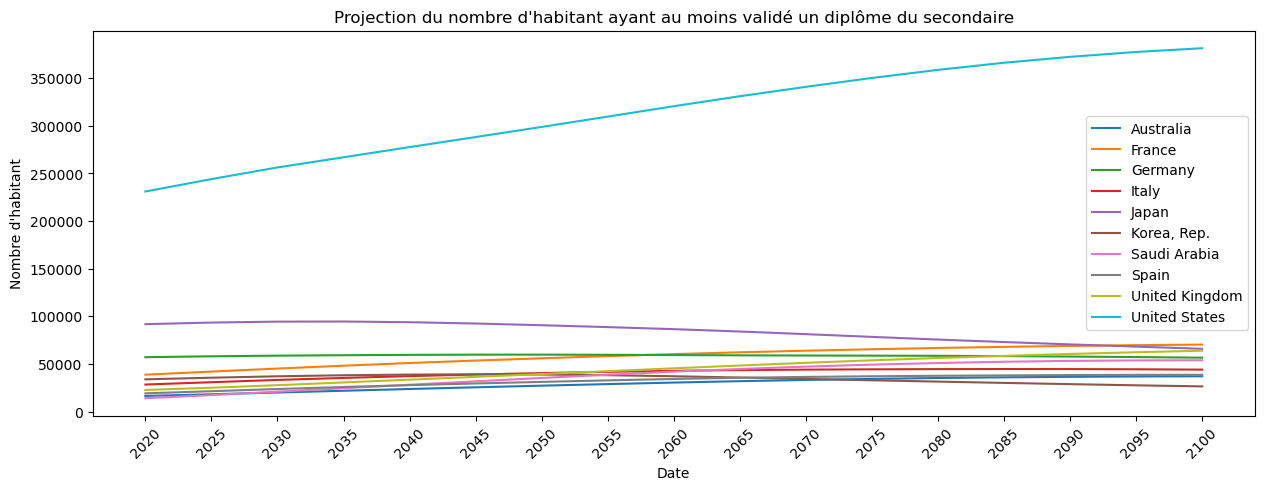

In [799]:
fig, ax = plt.subplots(figsize=(15,5))
for country in df_prev.index:
    ax.plot(df_prev.columns, df_prev.loc[country])
ax.legend(df_prev.index)
ax.set_title("Projection du nombre d'habitant ayant au moins validé un diplôme du secondaire")
ax.set_xlabel('Date')
ax.set_ylabel("Nombre d'habitant")
ax.set_xticklabels(labels=df_prev.columns, rotation=45)